In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('/content/drive/MyDrive/Discount_Sales Project/Sales Rev discount.csv')
dataset.head()

,CustomerKey,BirthDate,MaritalStatus,Gender,Education,Occupation,Income,Sales,DiscountAmt,DiscountPercent,Price
0,17,4/28/1979,M,M,Partial College,Skilled Manual,30000,410.4265,31.0735,0.0757,55.1875
1,19,10/9/1944,S,M,Partial College,Clerical,30000,179.9700,0.0000,NaN,59.9900
2,26,12/23/1945,M,M,Partial High School,Clerical,10000,179.9700,0.0000,NaN,59.9900
3,51,9/7/1951,M,M,High School,Skilled Manual,30000,59.9900,0.0000,NaN,59.9900
4,53,8/7/1951,S,F,Partial College,Clerical,40000,59.9900,0.0000,NaN,59.9900


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15073 entries, 0 to 15072
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerKey      15073 non-null  int64  
 1   BirthDate        15073 non-null  object 
 2   MaritalStatus    15073 non-null  object 
 3   Gender           15073 non-null  object 
 4   Education        15073 non-null  object 
 5   Occupation       15073 non-null  object 
 6   Income           15073 non-null  int64  
 7   Sales            15073 non-null  float64
 8   DiscountAmt      15073 non-null  float64
 9   DiscountPercent  7548 non-null   float64
 10  Price            15073 non-null  float64
dtypes: float64(4), int64(2), object(5)
memory usage: 1.3+ MB


### Data cleaning and exploration

* Remove CustomerKey
* Generate Age of customers from BirthDate column
* Convert NaN in Discount countPercent column to 0
* create treatment group from DiscountPercent:  0 = No discount, 5%, 10%, 20%

In [4]:
# Remove CustomerKey column

dataset = dataset.drop('CustomerKey',axis=1)

In [5]:
dataset.columns

Index(['BirthDate', 'MaritalStatus', 'Gender', 'Education', 'Occupation',
       'Income', 'Sales', 'DiscountAmt', 'DiscountPercent', 'Price'],
      dtype='object')

In [6]:
# Generate age from BirthDate column

import datetime

def from_dob_to_age(born):
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [7]:
dataset['BirthDate'] =  pd.to_datetime(dataset['BirthDate'])
dataset['Age']=dataset['BirthDate'].apply(lambda x: from_dob_to_age(x))

In [8]:
dataset.columns

Index(['BirthDate', 'MaritalStatus', 'Gender', 'Education', 'Occupation',
       'Income', 'Sales', 'DiscountAmt', 'DiscountPercent', 'Price', 'Age'],
      dtype='object')

In [9]:
# Replace NaN with 0

dataset['DiscountPercent'] = dataset['DiscountPercent'].fillna(0)

In [10]:
dataset['DiscountPercent'].value_counts(10)

0.0000    0.499237
0.0526    0.170105
0.0256    0.048696
0.0344    0.040602
0.1111    0.027732
            ...   
0.0475    0.000066
0.0396    0.000066
0.1045    0.000066
0.0068    0.000066
0.0480    0.000066
Name: DiscountPercent, Length: 300, dtype: float64

In [11]:
# Create a column to keep discount in %

dataset['dpct'] = round(dataset['DiscountPercent']*100,0)

In [12]:
dataset.head()

,BirthDate,MaritalStatus,Gender,Education,Occupation,Income,Sales,DiscountAmt,DiscountPercent,Price,Age,dpct
0,1979-04-28,M,M,Partial College,Skilled Manual,30000,410.4265,31.0735,0.0757,55.1875,43,8.0
1,1944-10-09,S,M,Partial College,Clerical,30000,179.9700,0.0000,0.0000,59.9900,78,0.0
2,1945-12-23,M,M,Partial High School,Clerical,10000,179.9700,0.0000,0.0000,59.9900,76,0.0
3,1951-09-07,M,M,High School,Skilled Manual,30000,59.9900,0.0000,0.0000,59.9900,71,0.0
4,1951-08-07,S,F,Partial College,Clerical,40000,59.9900,0.0000,0.0000,59.9900,71,0.0


In [13]:
dataset['dpct'].value_counts()

0.0     7527
5.0     2689
3.0     1557
4.0      725
7.0      723
8.0      465
11.0     419
6.0      371
2.0      346
9.0      124
1.0      105
10.0      22
Name: dpct, dtype: int64

For the purpose of this experiement, we shall utilize samples from those with zero discount as control, and treatments from those with 5% and 11%

In [14]:
# Select the necessary features and create dummy variables for the categorical variables

data = dataset.drop(['BirthDate','DiscountAmt','DiscountPercent'],axis=1)
data.head()

,MaritalStatus,Gender,Education,Occupation,Income,Sales,Price,Age,dpct
0,M,M,Partial College,Skilled Manual,30000,410.4265,55.1875,43,8.0
1,S,M,Partial College,Clerical,30000,179.9700,59.9900,78,0.0
2,M,M,Partial High School,Clerical,10000,179.9700,59.9900,76,0.0
3,M,M,High School,Skilled Manual,30000,59.9900,59.9900,71,0.0
4,S,F,Partial College,Clerical,40000,59.9900,59.9900,71,0.0


In [15]:
# Select the control and treatment groups

data_control = data.query('dpct==0.0')
data_treat = data.query('dpct==5.0')

In [16]:
data_control.shape,data_treat.shape

((7527, 9), (2689, 9))

In [17]:
# Select 800 from control and 650 from treatment

data_control_sample = data_control.sample(n=800,random_state=42)
data_treat_sample = data_treat.sample(n=650,random_state=42)

In [18]:
# Designate the samples as control and treament, then merge them 

data_control_sample['treatment'] = 0
data_treat_sample['treatment']=1

In [19]:
# combine the samples

df = pd.concat([data_control_sample,data_treat_sample],axis=0)

In [20]:
df.head()

,MaritalStatus,Gender,Education,Occupation,Income,Sales,Price,Age,dpct,treatment
12173,S,F,Bachelors,Clerical,10000,59.99,59.99,85,0.0,0
3612,M,M,Bachelors,Management,60000,59.99,59.99,76,0.0,0
7009,M,M,Partial College,Skilled Manual,60000,119.98,59.99,47,0.0,0
11681,S,M,Partial College,Skilled Manual,40000,59.99,59.99,46,0.0,0
8725,S,F,Partial College,Clerical,30000,179.97,59.99,83,0.0,0


In [21]:
df.tail()

,MaritalStatus,Gender,Education,Occupation,Income,Sales,Price,Age,dpct,treatment
7093,M,F,Graduate Degree,Management,70000,227.9620,59.99,82,5.0,1
4929,M,M,Partial College,Professional,60000,170.9715,59.99,46,5.0,1
428,M,M,Partial College,Skilled Manual,40000,341.9430,59.99,47,5.0,1
8236,M,M,Bachelors,Professional,60000,170.9715,59.99,63,5.0,1
11103,S,F,Bachelors,Management,120000,341.9430,59.99,56,5.0,1


In [22]:
# remove dpct column

df = df.drop('dpct',axis=1)

In [23]:
# create dummy variables

df = pd.get_dummies(df,drop_first=True,prefix_sep=('*'))

In [24]:
df.head()

,Income,Sales,Price,Age,treatment,MaritalStatus*S,Gender*M,Education*Graduate Degree,Education*High School,Education*Partial College,Education*Partial High School,Occupation*Management,Occupation*Manual,Occupation*Professional,Occupation*Skilled Manual
12173,10000,59.99,59.99,85,0,1,0,0,0,0,0,0,0,0,0
3612,60000,59.99,59.99,76,0,0,1,0,0,0,0,1,0,0,0
7009,60000,119.98,59.99,47,0,0,1,0,0,1,0,0,0,0,1
11681,40000,59.99,59.99,46,0,1,1,0,0,1,0,0,0,0,1
8725,30000,179.97,59.99,83,0,1,0,0,0,1,0,0,0,0,0


In [25]:
# Rename columns with longer names

namesdf = {'Education*Graduate Degree':'graduate','Education*High School':'HighSchool','Education*Partial College':'PartialCollege',
           'Education*Partial High School':'PartialHighSc','Gender*M':'Male','MaritalStatus*S':'Single','Occupation*Management':'ManagerCdr',
           'Occupation*Manual':'ManualCdr','Occupation*Professional':'ProfessionalCdr','Occupation*Skilled Manual':'SkilledManualCdr'}

df = df.rename(columns=namesdf) 

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 12173 to 11103
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Income            1450 non-null   int64  
 1   Sales             1450 non-null   float64
 2   Price             1450 non-null   float64
 3   Age               1450 non-null   int64  
 4   treatment         1450 non-null   int64  
 5   Single            1450 non-null   uint8  
 6   Male              1450 non-null   uint8  
 7   graduate          1450 non-null   uint8  
 8   HighSchool        1450 non-null   uint8  
 9   PartialCollege    1450 non-null   uint8  
 10  PartialHighSc     1450 non-null   uint8  
 11  ManagerCdr        1450 non-null   uint8  
 12  ManualCdr         1450 non-null   uint8  
 13  ProfessionalCdr   1450 non-null   uint8  
 14  SkilledManualCdr  1450 non-null   uint8  
dtypes: float64(2), int64(3), uint8(10)
memory usage: 82.1 KB


In [43]:
df.to_csv('cleandiscount.csv')

# Analysis of Causal Effect

In [ ]:
!pip install causallib

In [28]:
X = df.drop(['Sales','treatment'],axis=1)
y = df['Sales']
a = df['treatment']

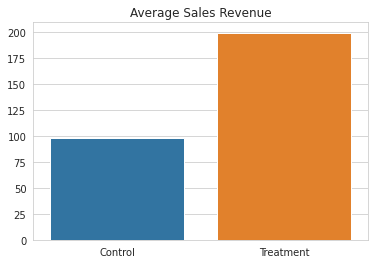

Difference between Control and Treatment 101.69268


In [29]:
sns.set_style("whitegrid")
sns.barplot(x = ['Control', 'Treatment'], y = df.groupby('treatment')['Sales'].mean().values)
plt.title('Average Sales Revenue')
plt.show()
print(f'Difference between Control and Treatment {np.round(df.groupby("treatment")["Sales"].mean()[1] - df.groupby("treatment")["Sales"].mean()[0], 5)}')

The mean difference betwwen the treament and the control suggests that the 5% discount makes a difference to the sales revenue.  We need to go further to probe the authenticity of this result by check the distribution of the covariates between the control and treatment group.

In [30]:
# check for covariate balance

from causallib.metrics.weight_metrics import calculate_covariate_balance

In [31]:
calculate_covariate_balance(X,a,w=a*0+1)["unweighted"].sort_values()

covariate
Male                0.022440
PartialCollege      0.029646
HighSchool          0.045169
Age                 0.069082
ManagerCdr          0.137595
Single              0.146021
ProfessionalCdr     0.169472
PartialHighSc       0.193529
graduate            0.248758
Price               0.250839
Income              0.252841
SkilledManualCdr    0.288191
ManualCdr           0.526871
Name: unweighted, dtype: float64

In [32]:
X.groupby(a).mean()

,Income,Price,Age,Single,Male,graduate,HighSchool,PartialCollege,PartialHighSc,ManagerCdr,ManualCdr,ProfessionalCdr,SkilledManualCdr
treatment,,,,,,,,,,,,,
0,52737.500000,57.068361,60.052500,0.497500,0.511250,0.121250,0.161250,0.316250,0.121250,0.141250,0.232500,0.246250,0.172500
1,63753.846154,59.508663,61.155385,0.395385,0.495385,0.256923,0.138462,0.296923,0.046154,0.215385,0.006154,0.355385,0.347692


The covariate balance statistics reveal that the sample is biased against the control group.  For instance, the Income level of those in the treatment group is $11 more than those in the control group, while the grduates in the treatement group are 11% higher than those in the control group, similarly those in the managerial cadre for the treatment group are about 7% higher than those in the control group.  In short, the data is seriously skewed in favor of the treatment group which could explain the seemingly large difference between the mean sales revenue observed between the two groups.

### Causal evaluation with imbalance covariates

In [33]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from causallib.estimation import (
    PropensityFeatureStandardization,
    WeightedStandardization,
    AIPW,
    IPW,
    MarginalOutcomeEstimator,
    Standardization,
    StratifiedStandardization,
    Matching,
    PropensityMatching,
)
from causallib.preprocessing.transformers import MatchingTransformer


def learner(): return LogisticRegression(
    solver="liblinear", class_weight="balanced", max_iter=5000)


def makeipw(): return IPW(learner=learner())
def makestd(): return StratifiedStandardization(learner=LinearRegression())


all_estimators = [
    MarginalOutcomeEstimator(learner=LinearRegression()),
    Matching(with_replacement=False),
    PropensityMatching(learner=learner(), caliper=0.1),
    IPW(learner=learner()),
    Standardization(learner=LinearRegression()),
    StratifiedStandardization(learner=LinearRegression()),
]


def get_all_estimates(X, a, y):
    estimates = {}
    for estimator in all_estimators:
        estimator.fit(X, a, y)
        estimator_name = estimator.__class__.__name__
        estimates[estimator_name] = estimator.estimate_population_outcome(
            X, a, y)
    estimates_df = pd.concat(estimates, axis=1).T
    return estimates_df

In [34]:
import warnings
warnings.filterwarnings('ignore')
all_estimates = get_all_estimates(X, a, y)
all_estimates.assign(ATE=all_estimates[1] - all_estimates[0])

,0,1,ATE
MarginalOutcomeEstimator,97.541550,199.234225,101.692675
Matching,102.154769,199.234225,97.079456
PropensityMatching,99.088559,236.297408,137.208850
IPW,97.695622,202.955503,105.259881
Standardization,96.213865,200.868300,104.654435
StratifiedStandardization,98.576357,251.934577,153.358219


The ATE ranges from  $97  to  $153 in absence of correcting for the imbalance in covariates.  We shall use matching method to restrict the sample to the matching consumers.

### Restricting the sample to the matched cases

In [35]:
from causallib.preprocessing.transformers import PropensityTransformer
propensity_transform = PropensityTransformer(learner=learner(), include_covariates=True)

In [36]:
mt = MatchingTransformer(with_replacement=False, propensity_transform=propensity_transform)
Xm, am, ym = mt.fit_transform(X, a, y)
print(f"Transforming data from {X.shape[0]} samples to {Xm.shape[0]} samples by matching without replacement.")

Transforming data from 1450 samples to 1300 samples by matching without replacement.


### Checking for the covarite balance

In [37]:
ipw = IPW(learner=LogisticRegression(solver="liblinear", class_weight="balanced"))
ipw_m = IPW(learner=learner())
ipw_m.fit(Xm, am)
wm = ipw_m.compute_weights(Xm, am)
calculate_covariate_balance(Xm, am, wm)

abs_smd,weighted,unweighted
covariate,,
Income,0.003316,0.166706
Price,0.011119,0.042123
Age,0.007187,0.017080
Single,0.084084,0.094740
Male,0.012856,0.013055
graduate,0.168588,0.194069
HighSchool,0.003367,0.030802
PartialCollege,0.018850,0.025986
PartialHighSc,0.016893,0.039103


The covariates are now substantially balance with the total sample reduced from 1450 to 1300.  Most especially, the income variable which is one of the principal determinants of demand is now balanced.  Next, we shall go ahead and re-estimate our model given that we are now comparing similar datasets

In [38]:
all_estimates_matched = get_all_estimates(Xm, am, ym)
all_estimates_matched.assign(ATE=all_estimates_matched[1] - all_estimates_matched[0])

,0,1,ATE
MarginalOutcomeEstimator,101.766462,199.234225,97.467764
Matching,101.766462,199.234225,97.467764
PropensityMatching,98.511862,221.264150,122.752289
IPW,101.266869,202.179942,100.913073
Standardization,98.954411,202.046276,103.091865
StratifiedStandardization,101.184621,211.780988,110.596368


### Evaluation

### Continuous accuracy and residuals

In [39]:
from causallib.evaluation import evaluate

In [40]:
cont_std = StratifiedStandardization(LinearRegression())
cont_std.fit(Xm, am, ym)
cont_std_results = evaluate(cont_std, Xm, am, ym, cv="auto")
cont_std_results.all_plot_names

frozenset({'common_support', 'continuous_accuracy', 'residuals'})

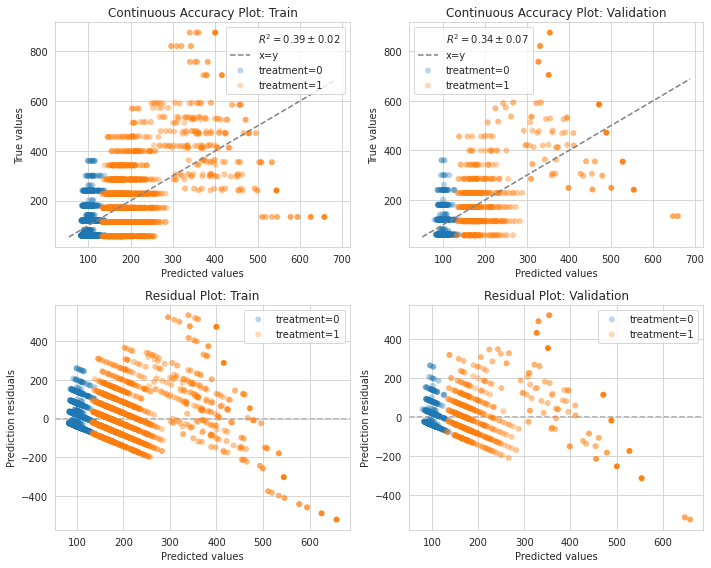

In [41]:
f, axes = plt.subplots(2, 2, figsize=(10, 8))
row1, row2 = axes
cont_std_results.plot_continuous_accuracy(phase="train", ax=row1[0])
cont_std_results.plot_continuous_accuracy(phase="valid", ax=row1[1])
cont_std_results.plot_residuals(phase="train", ax=row2[0])
cont_std_results.plot_residuals(phase="valid", ax=row2[1])
plt.tight_layout()

# to add the train validation annotation to the titles:
for row in axes: 
    for idx, suffix in [(0, "Train"), (1 ,"Validation")]:
        row[idx].set_title(row[idx].get_title() + ": " + suffix)

### Common Support Validation Plot

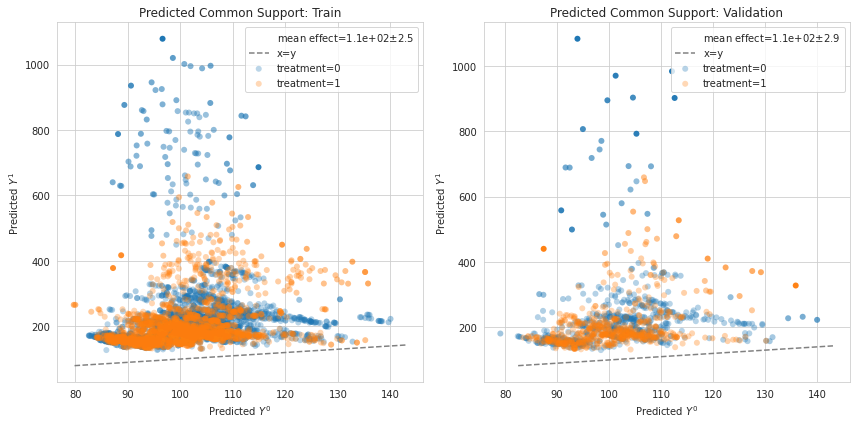

In [42]:
fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
cont_std_results.plot_common_support(phase="train", ax=a0)
cont_std_results.plot_common_support(phase="valid", ax=a1)
for ax, suffix in [(a0, "Train"), (a1 ,"Validation")]:
    ax.set_title(ax.get_title() + ": " + suffix)
_ = plt.tight_layout()

### Conclusions

The results have been revised based on adjustments made to the sample.  One striking adjustment we found in this result is that, StrarifeiedStandardization which was estimated ATE to be 153 dollars before matching revised its estimates trastically downward to 110 dollars.  Looking at the results overall, we can conclude that a 5% discount produces an average of 100 dollars increase in Sales Revenue.